In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
from analyze2p.utils import gratings as gutils
from analyze2p.utils import plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils.helpers as hutils

In [3]:
from analyze2p.utils import rfs as rfutils
from analyze2p.utils import rois as roiutils
from analyze2p.utils import retino as retutils

In [4]:
%matplotlib notebook

In [5]:
# import allensdk as ak
import analyze2p.correlations as cr


# Plotting

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

bw_colors = dict((v, [0.7]*3) for v in visual_areas)


# Source

In [405]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

experiment = 'blobs'
response_type='dff'
responsive_test='nstds'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20
print(responsive_test, responsive_thr)

#### Responsive params
if experiment=='gratings':
    resp_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
else:
    resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)

data_id = '|'.join([traceid, resp_desc])
print(data_id)

nstds 10.0
traces001|dff_responsive-nstds-thr10.00


# Output dir

In [406]:
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       '%s_%s_%s' % (experiment, response_type, responsive_test))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_nstds


# Load metadata

In [407]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin([experiment])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())


/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
|    |   visual_area |
|:---|--------------:|
| Li |            19 |
| Lm |            18 |
| V1 |            16 |


# Load trial metrics

In [408]:
trial_epoch='stimulus' #'stimulus'
NDATA0 = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, verbose=False,
                      responsive_thr=responsive_thr, n_stds=n_stds)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15.0 0.0], y: [-5.0 0.0]


# Load fits

In [409]:
if experiment == 'gratings':
    gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, 
                                fit_desc=resp_desc, return_missing=True) 
    gdata = hutils.split_datakey(gdata)
    # Get best GoF for each 
    best_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
    assert gdata.loc[best_ixs].groupby(['visual_area', 'datakey', 'cell'])\
            .count().max().max()==1
    bestg = gdata.loc[best_ixs].copy()
    bestg = hutils.split_datakey(bestg)
    print(bestg[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
    fit_thr=0.5
    counts = bestg[bestg['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
elif experiment == 'rfs':
    # load fits, too
    # etc.
    pass
else:
    meanr = NDATA0.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()
    best_ixs = meanr.groupby(['visual_area', 'datakey', 'cell'])['response']\
                    .transform(max) == meanr['response']
    assert meanr.loc[best_ixs].groupby(['visual_area', 'datakey', 'cell'])\
            .count().max().max()==1
    bestg = meanr.loc[best_ixs].copy()

    counts = CELLS.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
    counts = hutils.split_datakey(counts)

# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts)

[V1] Animalid does not exist: JC078 


# Load trial data

#### Filter fits

In [410]:
# Drop repeat FOVs based on N fits
NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
print(NDATA[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())


|    |   visual_area |
|:---|--------------:|
| V1 |          1651 |
| Lm |          1302 |
| Li |           905 |


In [411]:
%matplotlib inline

In [412]:
gdata_u = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])
                if (va, dk) in u_dkeys])
print(gdata_u['visual_area'].value_counts().to_markdown())

if experiment=='gratings':
    gof_thr=0.5
    final_dkeys = [u[1] for u in u_dkeys]
    final_fits = bestg[(bestg['gof']>=gof_thr) 
                     & (bestg.datakey.isin(final_dkeys))].copy()
    print(final_fits['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |          1651 |
| Lm |          1302 |
| Li |           905 |


# Example FOV & CELL

In [413]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [414]:
va = 'V1'
dk='20190617_JC097_fov1'
selective_only=False

ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# Select cells
if selective_only:
    curr_cells = gdata_u[(gdata_u.visual_area==va) 
                    & (gdata_u.datakey==dk)]['cell'].unique()
    if len(curr_cells)<5:
        print("Skipping.")
        #continue
else:
    curr_cells = ndf['cell'].unique()
    
# Select stimuli and trials
sdf = aggr.get_stimuli(dk, experiment=experiment)
curr_cfgs = sdf.index.tolist()
corrs, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                 curr_cells=curr_cells, curr_cfgs=curr_cfgs)


In [415]:
# Get mean response per condition (columns=cells, rows=conditions)
if experiment=='gratings':
    params=['ori', 'sf', 'size', 'speed']
elif experiment=='blobs':
    params=['morphlevel', 'size'] #, 'yrot', 'xpos', 'ypos']
tuning_ = cr.trial_averaged_responses(zscored, sdf, params=params)
rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]

#### Representational Similarity Matrix

In [416]:
if experiment == 'gratings':
    sdf['tf'] = sdf['sf']*sdf['speed']
    xlabels = ['%i|%.2f|%i|%i' % (o, sf, sz, sp) for (o, sf, sz, sp) in \
               sdf.loc[tuning_['config']][['ori', 'sf', 'size', 'speed']].values]
else:
    xlabels = ['%i|%.i' % (mp, sz) for (mp, sz) in\
               sdf.loc[tuning_['config']][params].values]
mat_ = tuning_[rois_].T.corr(method='spearman')
msk_ = np.triu(np.ones_like(mat_, dtype=bool))

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_nstds rdm__EXAMPLE_20190617_JC097_fov1


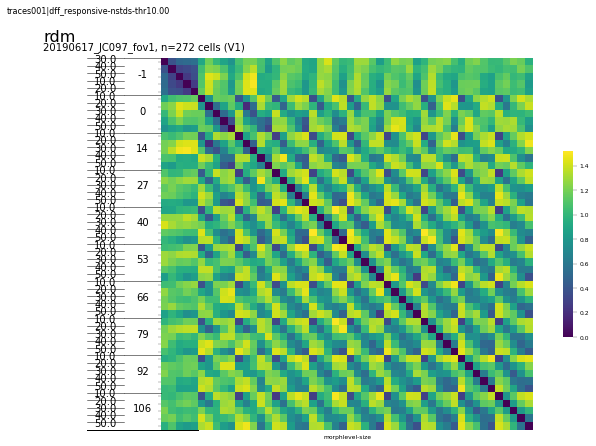

In [417]:
plot_rdm = True

if plot_rdm:
    pmat = 1-mat_
    cmap='viridis' # 0=totally same, 2+ more dissimilar
    plot_name = 'rdm'
else:
    pmat = mat_.copy()
    cmap = 'RdBu_r' # red, corr=1, blue, anticorr=-1
    plot_name = 'corr'
    
fig, ax = pl.subplots(1,1,figsize=(10, 6))
sns.heatmap(pmat, cmap=cmap, ax=ax, #mask=msk_, 
            square=True, cbar_kws={"shrink": 0.5})

#ax.set_aspect('equal')
fig.text(0.05, 0.9, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

#Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_ylabel('')
ax.set_xticks([])

pplot.label_group_bar_table(ax, mat_, offset=0.1, lw=0.5)
fig.subplots_adjust(bottom=.01*mat_.index.nlevels, left=0.05, right=0.9)
fig.text(0.05, 0.92, plot_name, fontsize=16)

pplot.label_figure(fig, data_id)

figname = '%s__EXAMPLE_%s' % (plot_name, dk)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## Correlations

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


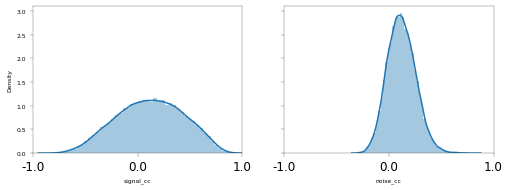

In [418]:
fig, axn = pl.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
sns.distplot(corrs['signal_cc'], ax=axn[0])
sns.distplot(corrs['noise_cc'], ax=axn[1])
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.set_xticks(np.linspace(-1, 1, 3))
    ax.set_xticklabels(np.linspace(-1, 1, 3), fontsize=12)
pl.subplots_adjust(bottom=0.2, left=0.1)

## Signal corrs. vs. Cortical distance

#### Load spatial info

In [419]:
session, animalid, fovnum = hutils.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovnum

# Position info
rois_ = ndf['cell'].unique()
fcoords = roiutils.load_roi_coords(animalid, session, fov, traceid=traceid)
pos_ = fcoords['roi_positions'].loc[rois_].copy()

In [420]:
# Add cortical distances
cc_ = corrs.copy()
cc_ = cr.get_pw_cortical_distance(cc_, pos_)
cc_['visual_area'] = va
cc_['datakey'] = dk
cc_.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,0,1,0.876113,0_1,0.827507,14.677900,V1,20190617_JC097_fov1
1,0,2,-0.313676,0_2,-0.046407,53.353902,V1,20190617_JC097_fov1
2,0,3,0.276738,0_3,0.328402,79.267714,V1,20190617_JC097_fov1
3,0,4,-0.139675,0_4,0.018574,24.855400,V1,20190617_JC097_fov1
4,0,5,0.053038,0_5,0.077309,40.316287,V1,20190617_JC097_fov1


|   binned_cortical_distance |   cortical_distance |   signal_cc |
|---------------------------:|--------------------:|------------:|
|                          0 |             161.734 |    0.149042 |
|                          1 |             329.902 |    0.133037 |
|                          2 |             481.42  |    0.118912 |
|                          3 |             720.143 |    0.077171 |
First and Last ~cortical_distance~ quartiles, diff <signal_cc> = -0.09
signal_cc_Q_cortical_distance__EXAMPLE_20190617_JC097_fov1


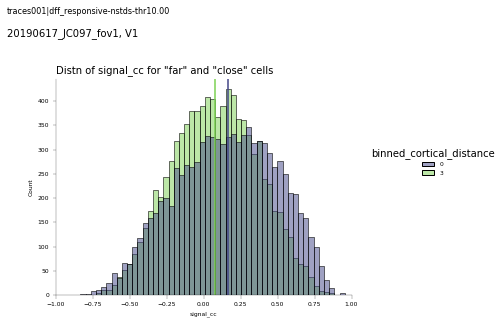

In [421]:
n_bins=4
use_quartile=True
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
qcolors = dict((k, v) for k, v in zip(np.arange(0, n_bins), qcolor_list))
# Bin into quartiles
to_quartile='cortical_distance'
cc_ = cr.bin_column_values(cc_, to_quartile=to_quartile, use_quartile=use_quartile,
                     n_bins=n_bins)
# Plot metric X for top and bottom quartiles
metric = 'signal_cc'
plot_bins = [0,3] # [0, 1, 2, 3]
print(cc_.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]].mean().to_markdown())

g = cr.plot_quartiles_vs_distance(cc_, to_quartile=to_quartile,
                              plot_bins=plot_bins, metric=metric,
                              qcolors=qcolors)
pl.subplots_adjust(bottom=0.2)
g.fig.axes[0].set_xlim([-1, 1])
# print some stuff
lo_median = cc_[cc_['binned_%s' % to_quartile]==0][metric].median()
hi_median = cc_[cc_['binned_%s' % to_quartile]==3][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.label_figure(g.fig, data_id)
g.fig.text(0.0, 0.92, '%s, %s' % (dk, va))
g.fig.axes[0].set_title('Distn of %s for "far" and "close" cells' % metric, loc='left', 
                  fontsize=10)
figname = '%s_Q_%s__EXAMPLE_%s' % (metric, to_quartile, dk)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

## Signal corr. vs RF overlap

In [422]:
%matplotlib notebook

In [423]:
# Load RF data
do_spherical_correction=False
# Get cells and metadata
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 
# Load RF fit data
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4


In [424]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
rfs_ = combined_rfs[(combined_rfs.visual_area==va) & (combined_rfs.datakey==dk)
                   & (combined_rfs['cell'].isin(rois_))].copy()
rfs_.index = rfs_['cell'].values

# Get rf overlaps
rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
overlaps_ = rfutils.get_rf_overlaps(rf_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 in overlaps_[['cell_1', 'cell_2']].values]

# merge RF and CC/distance data
has_both = np.intersect1d(overlaps_['neuron_pair'], cc_['neuron_pair'])
ccrf_ = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
               cc_[cc_['neuron_pair'].isin(has_both)])

|   binned_signal_cc |   signal_cc |   area_overlap |
|-------------------:|------------:|---------------:|
|                  0 |   -0.228767 |       0.402263 |
|                  1 |    0.153566 |       0.449106 |
|                  2 |    0.378178 |       0.49072  |
|                  3 |    0.629105 |       0.563466 |
First and Last ~signal_cc~ quartiles, diff <area_overlap> = 0.20


<IPython.core.display.Javascript object>


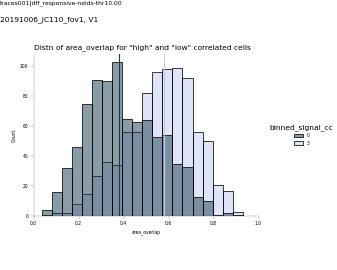

area_overlap_Q_signal_cc__EXAMPLE_20191006_JC110_fov1


In [430]:
n_bins=4
use_quartile=True
qcolor_list = sns.color_palette('cubehelix', n_colors=n_bins)
qcolors = dict((k, v) for k, v in zip(np.arange(0, n_bins), qcolor_list))
# Bin into quartiles
to_quartile='signal_cc'
ccrf_ = cr.bin_column_values(ccrf_, to_quartile=to_quartile, use_quartile=use_quartile,
                     n_bins=n_bins)
# Plot metric X for top and bottom quartiles
metric = 'area_overlap'
plot_bins = [0,3] # [0, 1, 2, 3]
print(ccrf_.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]].mean().to_markdown())
# print some stuff
lo_median = ccrf_[ccrf_['binned_%s' % to_quartile]==0][metric].median()
hi_median = ccrf_[ccrf_['binned_%s' % to_quartile]==3][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))

g = cr.plot_quartiles_vs_distance(ccrf_, to_quartile=to_quartile,
                              plot_bins=plot_bins, metric=metric,
                              qcolors=qcolors)
pl.subplots_adjust(bottom=0.2)
g.fig.axes[0].set_xlim([0, 1])


pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.label_figure(g.fig, data_id)
g.fig.text(0.0, 0.92, '%s, %s' % (dk, va))
g.fig.axes[0].set_title('Distn of %s for "high" and "low" correlated cells'\
                    % metric, loc='left', fontsize=10)
figname = '%s_Q_%s__EXAMPLE_%s' % (metric, to_quartile, dk)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Aggregate correlation metrics

In [431]:
importlib.reload(roiutils)

<module 'analyze2p.utils.rois' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/utils/rois.py'>

In [432]:
#### Get cell position data
NDATA['experiment'] = experiment
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = aggr.add_roi_positions(posdf)

Adding ROI position info...


In [433]:
ignore = ['20190320_JC067_fov1', '20190321_JC070_fov1', '20191111_JC120_fov1']
redo_pos = []
for (va, dk), g in posdf.groupby(['visual_area', 'datakey']):
    if len(g['ml_pos'].unique())==1:
        redo_pos.append(dk)
print(redo_pos)
for dk in redo_pos:
    if dk in ignore: 
        continue
    session, animalid, fovnum = hutils.split_datakey_str(dk)
    fovinfo = roiutils.load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                      traceid=traceid, create_new=True)

['20191111_JC120_fov1']


In [434]:
#ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# NDATA already contains only unique dkeys
min_ncells=5
selective_only=False
c_list=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) 
                        & (gdata_u.datakey==dk)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment=experiment)
    curr_cfgs = sdf.index.tolist()
    cc_, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
    # Get position info
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    cc_ = cr.get_pw_cortical_distance(cc_, pos_)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_list.append(cc_)
CORRS = pd.concat(c_list)
CORRS.head()

Skipping - (Lm, 20191111_JC120_fov1)


,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,85,86,0.320691,85_86,0.220087,34.619896,Li,20190315_JC070_fov1
1,85,99,0.350800,85_99,0.316383,40.044448,Li,20190315_JC070_fov1
2,85,102,0.290569,85_102,0.376465,182.860025,Li,20190315_JC070_fov1
3,85,103,0.409415,85_103,0.601003,151.733106,Li,20190315_JC070_fov1
4,85,104,0.467891,85_104,0.443382,169.820825,Li,20190315_JC070_fov1


In [435]:
%matplotlib notebook

<IPython.core.display.Javascript object>


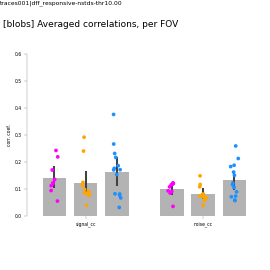

In [436]:
meancorrs = CORRS.groupby(['visual_area', 'datakey'])[['signal_cc', 'noise_cc']]\
                .mean() #.reset_index()
df_s = meancorrs.stack()\
    .rename_axis(index={'id': 'id', 'date': 'date', None: 'corr_type'})\
    .rename('corr_value').reset_index()

g = sns.FacetGrid(df_s, height=5)
g.map_dataframe(sns.stripplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=area_colors, 
                hue_order=visual_areas, dodge=True)
g.map_dataframe(sns.barplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=bw_colors, 
                hue_order=visual_areas, dodge=True)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.change_width(g.fig.axes[0], 0.2)
sns.despine(bottom=True)
pl.ylim([0, 0.6])
pl.ylabel('corr. coef.')
pplot.label_figure(g.fig, data_id)
g.fig.text(0.01, 0.9,'[%s] Averaged correlations, per FOV' % experiment, fontsize=12)

plot_type = 'selectiveonly' if selective_only else 'allcells'
figname = 'correlations_byfov_%s' % plot_type
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [437]:
CORRS.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,85,86,0.320691,85_86,0.220087,34.619896,Li,20190315_JC070_fov1
1,85,99,0.350800,85_99,0.316383,40.044448,Li,20190315_JC070_fov1
2,85,102,0.290569,85_102,0.376465,182.860025,Li,20190315_JC070_fov1
3,85,103,0.409415,85_103,0.601003,151.733106,Li,20190315_JC070_fov1
4,85,104,0.467891,85_104,0.443382,169.820825,Li,20190315_JC070_fov1


## Signal corrs for near vs. far cells

|               |   cortical_distance |   signal_cc |
|:--------------|--------------------:|------------:|
| ('Li', '<1')  |             147.82  |   0.199288  |
| ('Li', '1-2') |             306.778 |   0.14577   |
| ('Li', '2-3') |             452.996 |   0.132408  |
| ('Li', '>3')  |             659.046 |   0.128968  |
| ('Lm', '<1')  |             149.037 |   0.163922  |
| ('Lm', '1-2') |             310.382 |   0.131654  |
| ('Lm', '2-3') |             460.38  |   0.110213  |
| ('Lm', '>3')  |             703.742 |   0.0986824 |
| ('V1', '<1')  |             149.686 |   0.181994  |
| ('V1', '1-2') |             309.667 |   0.157775  |
| ('V1', '2-3') |             460.347 |   0.134255  |
| ('V1', '>3')  |             708.021 |   0.106868  |


<IPython.core.display.Javascript object>


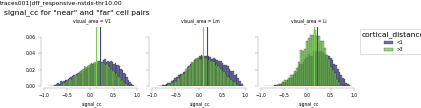

signal_cc_Q_cortical_distance_aggr


In [438]:
n_bins=4
custom_bins=False
use_quartile = False if custom_bins else True
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin into quartiles
bins = [0, 200, 350, 500, 5000] if custom_bins else np.arange(0, n_bins+1).astype(int)
bin_labels = cr.custom_bin_labels(bins) #if custom_bins else bins[0:-1]
qcolors = dict((k, v) for k, v in zip(bin_labels, qcolor_list))

to_quartile='cortical_distance'
bcorrs = cr.bin_column_values(CORRS, to_quartile=to_quartile, 
                     use_quartile=use_quartile,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs.head()
# Plot metric X for top and bottom quartiles
metric = 'signal_cc'
plot_bins = [bin_labels[0], bin_labels[-1] ] # [0, 1, 2, 3]
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())
# PLOT.
currd = bcorrs[bcorrs['binned_%s' % to_quartile].isin(plot_bins)]    
g = sns.FacetGrid(data=currd, col='visual_area', col_order=visual_areas, 
                  height=2., aspect=1.3,
                  hue='binned_%s' % to_quartile, palette=qcolors) 
g.map(sns.histplot, metric, stat='probability',
     common_norm=False, common_bins=False)
g.fig.axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left',
                     title=to_quartile, fontsize=6)

for (va, b), c_ in currd.groupby(['visual_area', 'binned_%s' % to_quartile]):
    median_ = c_[c_['binned_%s' % to_quartile]==b][metric].median()
    ai = visual_areas.index(va)
    g.fig.axes[ai].axvline(x=median_, color=qcolors[b])
pl.subplots_adjust(left=0.1, bottom=0.2, right=0.85, top=0.75)
sns.despine(trim=True, offset=2)
pplot.label_figure(g.fig, data_id)

g.fig.text(0.01, 0.87, '%s for "near" and "far" cell pairs' % metric, fontsize=10)

figname = '%s_Q_%s_aggr' % (metric, to_quartile)
print(figname)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

#### by fov

In [439]:
plot_bins

['<1', '>3']

<IPython.core.display.Javascript object>


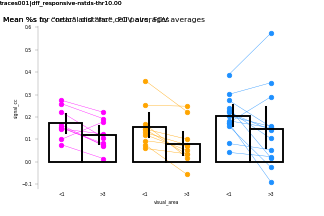

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        6 |   0.055 | V1            |
|  1 |        0 |   0.002 | Lm            |
|  2 |       23 |   0.127 | Li            |
signal_cc_Q_cortical_distance_byFOV


In [440]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()

fig, ax = pl.subplots()
metric='signal_cc'
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
print(pstats.to_markdown())
fig.text(0.01, 0.9, 'Mean %s for "near" and "far" cell pairs, FOV averages')

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

|    |   visual_area |
|:---|--------------:|
| Li |            13 |
| Lm |            10 |
| V1 |             9 |


<IPython.core.display.Javascript object>


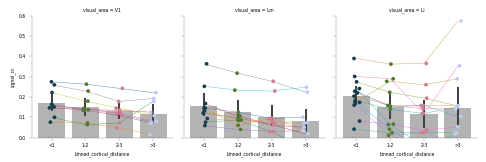

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


signal_cc_Q_cortical_distance_allbins_byFOV


In [441]:
print(means_[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
connect_fovs=True
bw_qcolors = dict((k, [0.7]*3) for k in bin_labels)
metric = 'signal_cc'
g = sns.FacetGrid(data=means_, col='visual_area', col_order=visual_areas,
                  hue='binned_%s' % to_quartile)
g.map(sns.stripplot, 'binned_%s' % to_quartile, metric, palette='cubehelix')
g.map(sns.barplot, 'binned_%s' % to_quartile, metric, palette=bw_qcolors)
pl.ylim([0, 0.6])
if connect_fovs:
    for va, fc in means_.groupby(['visual_area']):
        ai = visual_areas.index(va)
        ax = g.fig.axes[ai]
        sns.lineplot(x='binned_%s' % to_quartile, y=metric, data=fc,
                     lw=0.5, hue='datakey', ax=ax) #, linecolor='k')
        ax.legend_.remove()

fig.text(0.01, 0.9, 'Mean %s by cortical distance, FOV averages')

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [442]:
import scipy.stats as ss
for va, df_ in means_.groupby('visual_area'):
    samples = [b_df for b, b_df in df_.groupby('binned_%s' % to_quartile)[metric]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Name: {}, F value: {:.3f}, p value: {:.3f}'.format(va, f_val, p_val))


Name: Li, F value: 1.118, p value: 0.351
Name: Lm, F value: 1.334, p value: 0.279
Name: V1, F value: 1.215, p value: 0.320


In [443]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for va, df_ in means_.groupby('visual_area'):
    print('Name {}'.format(va), 
          pairwise_tukeyhsd(df_[metric], df_['binned_%s' % to_quartile]))


Name Li Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1-2    2-3  -0.0363 0.8807 -0.1702 0.0976  False
   1-2     <1   0.0544 0.6819 -0.0796 0.1883  False
   1-2     >3  -0.0043    0.9 -0.1383 0.1296  False
   2-3     <1   0.0907 0.2853 -0.0433 0.2246  False
   2-3     >3   0.0319    0.9  -0.102 0.1659  False
    <1     >3  -0.0587 0.6341 -0.1926 0.0752  False
---------------------------------------------------
Name Lm Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1-2    2-3  -0.0206    0.9 -0.1265 0.0852  False
   1-2     <1   0.0314 0.8383 -0.0744 0.1373  False
   1-2     >3  -0.0442 0.6586 -0.1501 0.0616  False
   2-3     <1   0.0521 0.5483 -0.0538  0.158  False
   2-3     >3  -0.0236    0.9 -0.1295 0.0823  False
    <1     >3  -0.0757  0.236 -0.1816 0.0302  Fa

# Receptive field position?

In [444]:
# Load RF data
do_spherical_correction=False
# Get cells and metadata
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 
# Load RF fit data
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4


In [445]:
# Get ROI positions
rfdf = aggr.add_roi_positions(combined_rfs)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in \
                     assigned_cells.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in rf_dkeys])

Adding ROI position info...


#### Combine GDATA and RFDATA

In [446]:
RFS=[]
GFS=[]
for (va, dk), gr_ in bestg.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) 
                      & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    #print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF0 = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
if experiment=='gratings':
    DF0['theta_deg'] = np.rad2deg(DF0['theta_Mm_c'])
    # Assign "preferred theta" for tested values
    theta_vals = np.linspace(0, 360, 9)
    print(theta_vals)
    print(DF0.dropna()['visual_area'].value_counts().to_markdown())
    DF0['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)== np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                                for t in DF0['theta_pref'].values]
    DF0['tested_theta'] = DF['tested_theta'].astype(float)

(1124, 6) (1124, 34)


In [447]:
DF0.tail()

,visual_area,datakey,cell,config,trial,response,animalid,aniso_index,anisotropy,ap_pos,...,session,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0
1119,V1,20191006_JC110_fov1,301,config002,840.151515,0.037069,JC110,-0.127230,0.194888,624.519765,...,20191006,10.921589,13.050073,8.793105,6.108721,-0.174464,350.003958,-0.174464,32.758629,3.102941
1120,V1,20191006_JC110_fov1,302,config031,845.848485,0.084137,JC110,-0.033032,0.204184,357.197652,...,20191006,6.638975,7.994547,5.283403,5.850719,-0.432466,335.221508,-0.432466,30.398411,-2.053308
1121,V1,20191006_JC110_fov1,307,config047,835.970588,0.064378,JC110,-0.037096,0.246521,338.761644,...,20191006,12.261988,15.284825,9.239150,0.438698,0.438698,25.135549,0.438698,34.280207,-1.863295
1122,V1,20191006_JC110_fov1,310,config001,833.147059,0.053763,JC110,-0.082874,0.125788,368.720157,...,20191006,9.473029,10.664619,8.281439,0.171417,0.171417,9.821492,0.171417,32.187542,-4.836219
1123,V1,20191006_JC110_fov1,336,config001,833.147059,0.036240,JC110,-0.225882,0.235024,345.675147,...,20191006,8.669491,6.631956,10.707025,1.551346,-0.019450,178.885573,1.551346,37.105320,-2.453987


In [448]:
counts = DF0.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
counts = hutils.split_datakey(counts)

# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts)

DF = pd.concat([g for (va, dk), g in DF0.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
DF.shape

[V1] Animalid does not exist: JC078 


(860, 37)

In [449]:
%matplotlib inline

|    |   visual_area |
|:---|--------------:|
| V1 |           500 |
| Lm |           226 |
| Li |           134 |


Text(0.01, 0.9, 'Pref. config for cells with both RF & <blobs> fits')

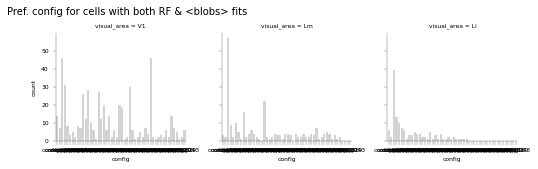

In [450]:
if experiment=='gratings':
    x='tested_theta'
elif experiment=='blobs':
    x='config'
print(DF.dropna()['visual_area'].value_counts().to_markdown())
g = sns.catplot(x=x, col='visual_area', data=DF, kind='count',
            height=2.5, col_order=visual_areas, color='lightgrey')
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
g.fig.text(0.01, 0.9, 'Pref. %s for cells with both RF & <%s> fits' % (x, experiment))

In [451]:
ndata_ccrf = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])
                       if (va, dk) in 
                        DF[['visual_area', 'datakey']].drop_duplicates().values.astype(tuple)
                       ])

In [452]:
print(ndata_ccrf[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())


|    |   visual_area |
|:---|--------------:|
| Li |            19 |
| Lm |            18 |
| V1 |            16 |


In [453]:
#ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# NDATA already contains only unique dkeys
min_ncells=5
selective_only=False
c_list=[]
for (va, dk), ndf in ndata_ccrf.groupby(['visual_area', 'datakey']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) 
                        & (gdata_u.datakey==dk)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment=experiment)
    curr_cfgs = sdf.index.tolist()
    cc_, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
    # Get position info
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    if len(pos_)==0:
        print("No position info: %s" % dk)
        continue
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    cc_ = cr.get_pw_cortical_distance(cc_, pos_)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_list.append(cc_)
CORRS = pd.concat(c_list)
CORRS.head()

No position info: 20190314_JC070_fov1
No position info: 20190327_JC073_fov1
No position info: 20190602_JC091_fov1
No position info: 20190606_JC091_fov1
No position info: 20190612_JC099_fov1
No position info: 20190327_JC073_fov1
No position info: 20190504_JC078_fov1
No position info: 20190508_JC083_fov1
No position info: 20190513_JC078_fov1
No position info: 20190517_JC083_fov1
No position info: 20190603_JC080_fov1
Skipping - (Lm, 20191111_JC120_fov1)
No position info: 20190420_JC076_fov1
No position info: 20190504_JC078_fov1
No position info: 20190507_JC083_fov1
No position info: 20190508_JC083_fov1
No position info: 20190509_JC078_fov1
No position info: 20190511_JC083_fov1
No position info: 20190517_JC083_fov1


,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,85,86,0.320691,85_86,0.220087,34.619896,Li,20190315_JC070_fov1
1,85,99,0.350800,85_99,0.316383,40.044448,Li,20190315_JC070_fov1
2,85,102,0.290569,85_102,0.376465,182.860025,Li,20190315_JC070_fov1
3,85,103,0.409415,85_103,0.601003,151.733106,Li,20190315_JC070_fov1
4,85,104,0.467891,85_104,0.443382,169.820825,Li,20190315_JC070_fov1


In [454]:
print(min_ncells)

5


In [455]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
r_list=[]
for (va, dk), cc_ in CORRS.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf.visual_area==va) 
                      & (rfdf.datakey==dk)].copy()
    if len(rfs_)<min_ncells:
        print("- skipping: %s, %s" % (va, dk))
        continue
    rfs_.index = rfs_['cell'].values
    # Get rf overlaps
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
    overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) \
                                for c1, c2 in overlaps_[['cell_1', 'cell_2']].values]
    # merge RF and CC/distance data
    has_both = np.intersect1d(overlaps_['neuron_pair'], cc_['neuron_pair'])
    ccrf_ = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
                   cc_[cc_['neuron_pair'].isin(has_both)])
    r_list.append(ccrf_)
CCRF = pd.concat(r_list, axis=0)

- skipping: Li, 20190315_JC070_fov1
- skipping: Li, 20190316_JC070_fov1
- skipping: Li, 20190319_JC067_fov1
- skipping: Li, 20190320_JC067_fov1
- skipping: Li, 20190321_JC070_fov1
- skipping: Li, 20190322_JC073_fov1
- skipping: Li, 20190422_JC076_fov1
- skipping: Li, 20191111_JC120_fov1
- skipping: Lm, 20190306_JC061_fov3
- skipping: Lm, 20190322_JC073_fov1
- skipping: Lm, 20190422_JC076_fov1
- skipping: Lm, 20191105_JC117_fov1


In [456]:
print(CCRF[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Lm |             7 |
| Li |             6 |


|               |   signal_cc |   area_overlap |
|:--------------|------------:|---------------:|
| ('Li', '<1')  |   -0.248098 |       0.313271 |
| ('Li', '1-2') |    0.132127 |       0.346366 |
| ('Li', '2-3') |    0.39398  |       0.398524 |
| ('Li', '>3')  |    0.62017  |       0.444141 |
| ('Lm', '<1')  |   -0.293937 |       0.305514 |
| ('Lm', '1-2') |    0.114923 |       0.31835  |
| ('Lm', '2-3') |    0.388175 |       0.365393 |
| ('Lm', '>3')  |    0.676178 |       0.474551 |
| ('V1', '<1')  |   -0.334729 |       0.44689  |
| ('V1', '1-2') |    0.128201 |       0.465126 |
| ('V1', '2-3') |    0.394448 |       0.496988 |
| ('V1', '>3')  |    0.65988  |       0.551729 |
area_overlapQ_signal_cc_aggr


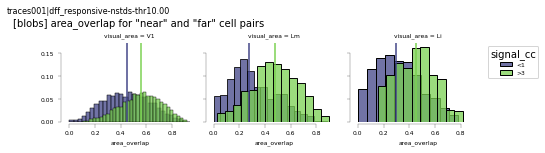

In [457]:
n_bins=4
custom_bins=False
use_quartile = False if custom_bins else True
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin into quartiles
bins = [0, 200, 350, 500, 5000] if custom_bins else np.arange(0, n_bins+1).astype(int)
bin_labels = cr.custom_bin_labels(bins) #if custom_bins else bins[0:-1]
qcolors = dict((k, v) for k, v in zip(bin_labels, qcolor_list))

to_quartile='signal_cc'
bcorrs = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
# Plot metric X for top and bottom quartiles
metric = 'area_overlap'
plot_bins = [bin_labels[0], bin_labels[-1] ] # [0, 1, 2, 3]
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())
# PLOT.
currd = bcorrs[bcorrs['binned_%s' % to_quartile].isin(plot_bins)]    
g = sns.FacetGrid(data=currd, col='visual_area', col_order=visual_areas, 
                  height=2., aspect=1.3,
                  hue='binned_%s' % to_quartile, palette=qcolors) 
g.map(sns.histplot, metric, stat='probability',
     common_norm=False, common_bins=False)
g.fig.axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left',
                     title=to_quartile, fontsize=6)
# Add vertical lines
for (va, b), c_ in currd.groupby(['visual_area', 'binned_%s' % to_quartile]):
    median_ = c_[c_['binned_%s' % to_quartile]==b][metric].median()
    ai = visual_areas.index(va)
    g.fig.axes[ai].axvline(x=median_, color=qcolors[b])
pl.subplots_adjust(left=0.1, bottom=0.2, right=0.85, top=0.75)
sns.despine(trim=True, offset=2)
pplot.label_figure(g.fig, data_id)

g.fig.text(0.01, 0.87, '[%s] %s for "near" and "far" cell pairs' \
           % (experiment, metric), fontsize=10)

figname = '%sQ_%s_aggr' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        0 |   0.004 | V1            |
|  1 |        1 |   0.062 | Lm            |
|  2 |        2 |   0.375 | Li            |
area_overlap_Q_signal_cc_byFOV /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_nstds


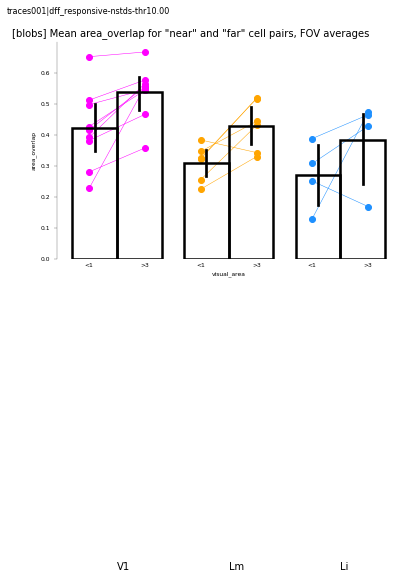

In [459]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()

fig, ax = pl.subplots()
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
print(pstats.to_markdown())
fig.text(0.01, 0.9, \
        '[%s] Mean %s for "near" and "far" cell pairs, FOV averages' \
        % (experiment, metric))


pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname, dst_dir)

# Spatial relationship?

In [327]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [351]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = aggr.add_roi_positions(posdf)

Adding ROI position info...


In [90]:
redo_pos = []
for (va, dk), g in posdf.groupby(['visual_area', 'datakey']):
    if len(g['ml_pos'].unique())==1:
        redo_pos.append(dk)
redo_pos

for dk in redo_pos:
    session, animalid, fovnum = hutils.split_datakey_str(dk)
    fovinfo = roiutils.load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                      traceid=traceid, create_new=True)

... calculating roi-2-fov info
... getting fov info
Created 255 contours for rois.
... (not sorting)
... calculating roi-2-fov info
... getting fov info
Created 280 contours for rois.
... (not sorting)
... calculating roi-2-fov info
... getting fov info
Created 190 contours for rois.
... (not sorting)


In [275]:
# selective_only=False
# stimulus_type='allstim'

# assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

# if stimulus_type=='fullscreen':
#     SD = fullSDF.copy()
# elif stimulus_type=='apertured':
#     SD = apSDF.copy()
# else:
#     SD = SDF.copy()
    
# roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
# print(roi_filter)

In [471]:
min_ncells=5
selective_only=False
c_=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
    # Select cells
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) 
                        & (passg.datakey==dk)]['cell'].unique()
    else:
        curr_cells = ndf['cell'].unique()
    if len(curr_cells)<min_ncells:
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment='gratings')
    curr_cfgs = sdf.index.tolist()
    cc_ = calculate_corrs(ndf, curr_cells=curr_cells, curr_cfgs=curr_cfgs)
    cc_['visual_area']=va
    cc_['datakey']=dk
    c_.append(cc_)
CC = pd.concat(c_, axis=0)


In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


In [472]:
c_ = []
for (va, dk), cc_ in CC.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    r1 = cc_['cell_1'].unique()
    r2 = cc_['cell_2'].unique()
    rois_ = np.union1d(r1, r2)
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[cc_['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[cc_['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    cc_['cortical_distance'] = dists
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_.append(cc_)
corrdist = pd.concat(c_, axis=0).reset_index(drop=True)


In [854]:
# Bin cortical distances for plotting
autosplit=False
if autosplit:
    n_bins_dist = 6
    use_quartile=False
    bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
    print("binning: %s" % bin_type)
    if use_quartile:
        corrdist['binned_dist'], bin_edges = pd.qcut(corrdist['cortical_distance'], \
                                        n_bins_dist, labels=False, retbins=True)
    else:
        corrdist['binned_dist'], bin_edges = pd.cut(corrdist['cortical_distance'], \
                                         n_bins_dist,labels=False, retbins=True)
else:
    bin_type='custombins'
    corrdist['binned_dist'] = pd.cut(x=corrdist['cortical_distance'], 
                                bins=[0, 100, 300, 500, np.inf], 
                                labels=['<100', '100-300', '300-500', '>500'])

mean_ccs = corrdist.groupby(['visual_area', 'datakey', 'binned_dist'])\
                        .mean().reset_index()

<IPython.core.display.Javascript object>


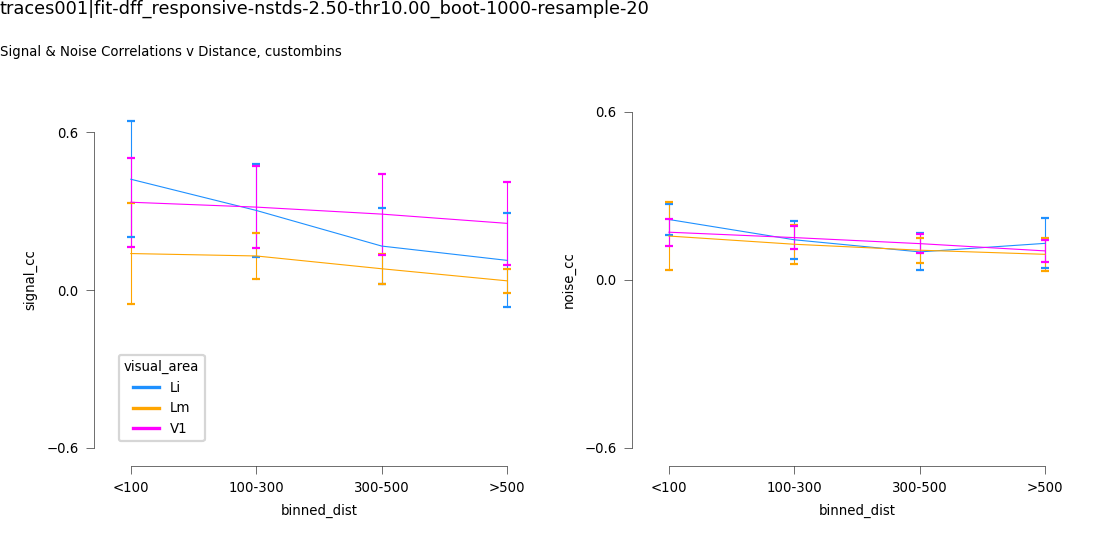

Text(0, 0.9, 'Signal & Noise Correlations v Distance, custombins')

In [855]:
lw=0.5

fig, axn = pl.subplots( 1, 2, figsize=(7,3.5)) #, sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['signal_cc', 'noise_cc']):
    sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, ci='sd', err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)
    #ax.set_xticks(list(range(len(bin_edges))))
    #ax.set_xticklabels([round(i) for i in bin_edges])
    #ax.set_ylim([-0.7, 0.7])
    ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])
    sns.despine(offset=8, trim=True, ax=ax)
    
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.3, hspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal & Noise Correlations v Distance, %s' % bin_type)
# figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,visual_area,datakey,cortical_distance,binned_dist,pref_theta_diff
0,172,187,-0.478374,172_187,0.044495,Li,20190314_JC070_fov1,217.661674,100-300,95.510204
1,172,216,0.727695,172_216,0.246881,Li,20190314_JC070_fov1,451.735098,300-500,-7.346939
2,172,220,0.783481,172_220,-0.004236,Li,20190314_JC070_fov1,456.918526,300-500,-7.346939
3,172,235,0.099065,172_235,-0.005421,Li,20190314_JC070_fov1,662.784857,>500,124.897959
4,172,253,0.135893,172_253,0.067974,Li,20190314_JC070_fov1,468.471708,300-500,-58.775510
...,...,...,...,...,...,...,...,...,...,...
18042,237,266,0.460840,237_266,0.240423,V1,20191006_JC110_fov1,172.559270,100-300,-161.632653
18043,237,313,0.504684,237_313,0.081655,V1,20191006_JC110_fov1,359.807776,300-500,51.428571
18044,245,266,0.708482,245_266,0.408278,V1,20191006_JC110_fov1,96.025434,<100,-168.979592
18045,245,313,0.457018,245_313,0.116141,V1,20191006_JC110_fov1,443.795066,300-500,44.081633


In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


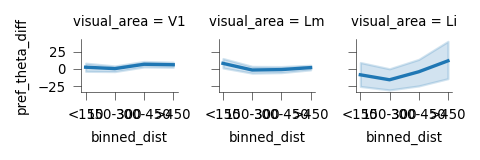

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

,visual_area,datakey,binned_dist,binned_theta,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,pref_theta_diff,abs_diff
40,Li,20190314_JC070_fov1,<150,-180.0,297.0,318.0,0.050655,0.433490,107.332928,-176.326531,176.326531
41,Li,20190314_JC070_fov1,<150,-140.0,279.0,297.0,-0.149087,-0.083493,107.157176,-154.285714,154.285714
43,Li,20190314_JC070_fov1,<150,-60.0,218.0,253.0,0.293214,0.181292,101.372948,-51.428571,51.428571
44,Li,20190314_JC070_fov1,<150,-20.0,254.0,270.5,0.541135,0.144238,93.358755,-18.367347,18.367347
51,Li,20190314_JC070_fov1,150-300,-140.0,211.0,259.5,-0.128815,0.023185,271.443274,-154.285714,154.285714


In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


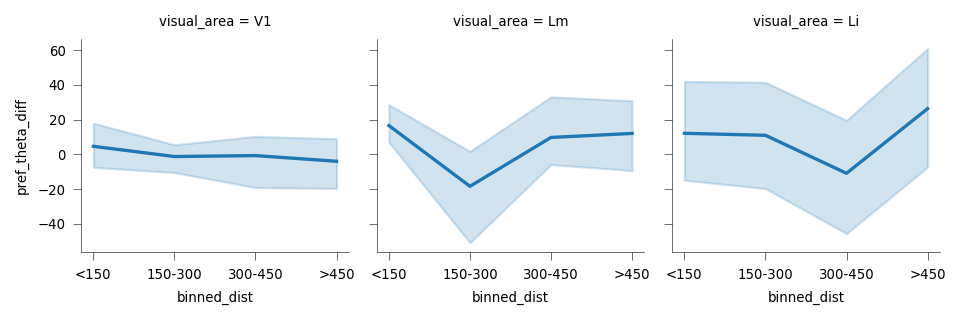

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


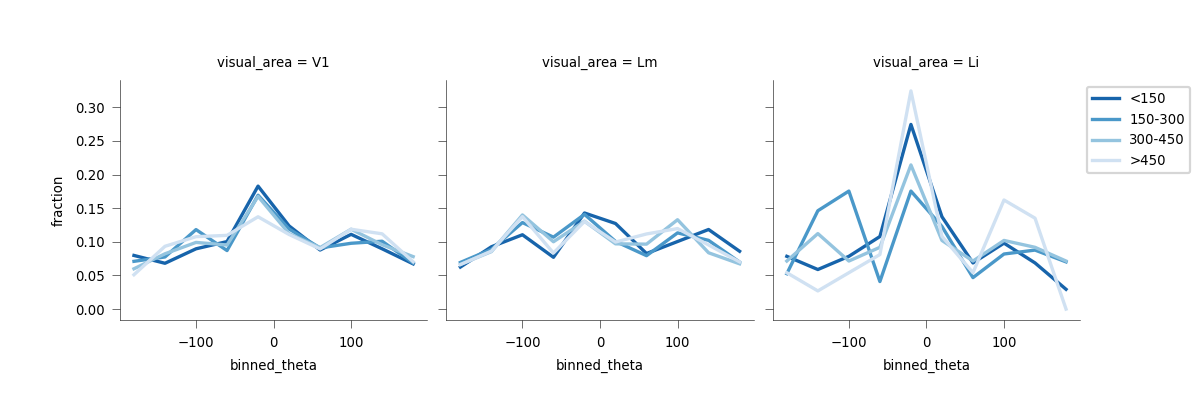

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


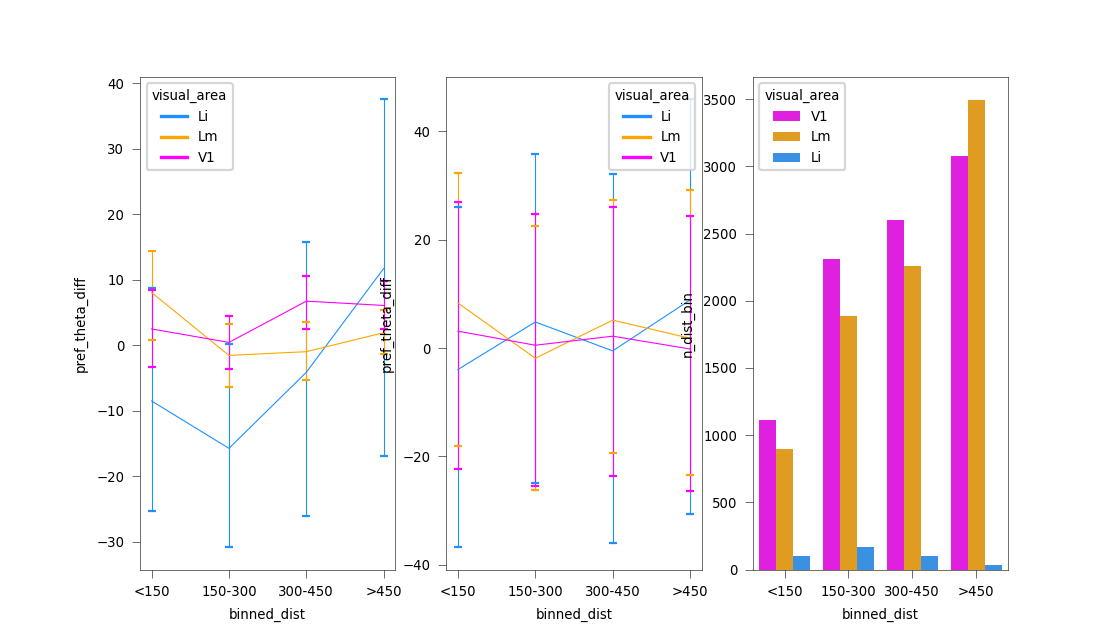

<AxesSubplot:xlabel='binned_dist', ylabel='n_dist_bin'>

In [1443]:
lw=0.5

fig, axn = pl.subplots(1,3,figsize=(7,4)) #, sharex=True, sharey=False)
# metric='abs_diff'
# metric = 'pref_deg_diff'
ax=axn[0]
sns.lineplot(x='binned_dist', y=metric, data=fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[1]
sns.lineplot(x='binned_dist', y=metric, data=mean_fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[2]
plotd = counts[['visual_area', 'binned_dist', 'n_dist_bin']].drop_duplicates()
sns.barplot(x='binned_dist', y='n_dist_bin', data=plotd, ax=ax,
           hue='visual_area', palette=area_colors, hue_order=visual_areas)